_Lambda School Data Science — Tree Ensembles_ 

# Decision Trees Assignment

## Part 1: House Price Regression

Apply decision trees to the Ames housing dataset you've worked with this week!

- Try multiple features
- Try features you've engineered
- Try different `max_depth` paramaters
- What's the best Test Root Mean Squared Error you can get? *Share with your cohort on Slack!*
- What's a cool visualization you can make? *Share with your cohort on Slack!*

In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

## Read CSV and clean the DataFrame

In [2]:
def dummyEncode(df):
    columnsToEncode = list(df.select_dtypes(include=['category', 'object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding: ' +feature)
    return df

In [3]:
# Read in CSV
ames_housing_data_url = 'https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv'
housing_df = pd.read_csv(ames_housing_data_url)

# Drop 5 features with the highest NaN count and `Id`
housing_df = housing_df.drop(columns=['PoolQC', 'MiscFeature', 
                                      'Alley', 'Fence', 'FireplaceQu', 'Id'])

# Encode non-numeric features using sklearn.preprocessing.LabelEncoder
non_numeric = housing_df.select_dtypes(exclude='number').columns
non_numeric_encoded = dummyEncode(housing_df[non_numeric].copy())
housing_df[non_numeric] = non_numeric_encoded

# Impute missing observations
housing_df[['GarageYrBlt', 'MasVnrArea']] = \
housing_df[['GarageYrBlt', 'MasVnrArea']].ffill()

# Validate type casting
housing_df.dtypes.value_counts()

Error encoding: MasVnrType
Error encoding: BsmtQual
Error encoding: BsmtCond
Error encoding: BsmtExposure
Error encoding: BsmtFinType1
Error encoding: BsmtFinType2
Error encoding: Electrical
Error encoding: GarageType
Error encoding: GarageFinish
Error encoding: GarageQual
Error encoding: GarageCond


int64      34
int32      27
object     11
float64     3
dtype: int64

## Fit decision tree with one feature

In [4]:
target = 'SalePrice'
features = ['OverallQual']
X = housing_df[features]
y = housing_df[target]

In [5]:
tree = DecisionTreeRegressor()
tree.fit(X, y)
print('R-squared / Model score: ', tree.score(X, y))

R-squared / Model score:  0.6841812868534439


## Fit with multiple engineered features

In [6]:
target = 'SalePrice'
features = ['OverallQual', 'GrLivArea', 'GarageArea', 'GarageCars', 
            '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
X = housing_df[features]
y = housing_df[target]

In [7]:
tree = DecisionTreeRegressor()
tree.fit(X, y)
print('R-squared / Model score: ', tree.score(X, y))

R-squared / Model score:  0.9998625911443951


## Try different `max_depth` sizes and calculate test-data root mean squared error

In [8]:
# X, y remain unchanged
X_train, X_test, y_train, y_test = \
train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)

In [9]:
for depth in range(1,16):
    tree = DecisionTreeRegressor(max_depth=depth)
    tree.fit(X_train, y_train)
    
    # Compare predictions to test target
    # RMSE calculates average accuracy
    rmse = (np.sqrt(mean_squared_error(y_test, tree.predict(X_test))))
    
    print('max_depth: {} \t model score: {} \t Test RMSE: {}'
          .format(depth, tree.score(X, y), rmse))

max_depth: 1 	 model score: 0.45401559803775915 	 Test RMSE: 65179.17817678443
max_depth: 2 	 model score: 0.632327729232963 	 Test RMSE: 50731.02770663903
max_depth: 3 	 model score: 0.7250675115797812 	 Test RMSE: 44135.11119771489
max_depth: 4 	 model score: 0.7798405539637231 	 Test RMSE: 45335.46884802031
max_depth: 5 	 model score: 0.844639512182637 	 Test RMSE: 35212.25350485763
max_depth: 6 	 model score: 0.8567362544706099 	 Test RMSE: 42666.6921891962
max_depth: 7 	 model score: 0.8979452754724753 	 Test RMSE: 36813.47790970657
max_depth: 8 	 model score: 0.9107689301116291 	 Test RMSE: 38817.69873465767
max_depth: 9 	 model score: 0.9245292158888978 	 Test RMSE: 38579.89408309443
max_depth: 10 	 model score: 0.9132514314776299 	 Test RMSE: 46695.52507763207
max_depth: 11 	 model score: 0.9244281963226136 	 Test RMSE: 45174.95881069965
max_depth: 12 	 model score: 0.9357680986510133 	 Test RMSE: 42778.09569908766
max_depth: 13 	 model score: 0.9438553785485027 	 Test RMSE: 40

In [10]:
tree = DecisionTreeRegressor(max_depth=12)
tree.fit(X_train, y_train)
print(tree.tree_.node_count)
print(tree.tree_.children_left)
print(tree.tree_.children_right)
print(tree.tree_.feature)
print(tree.tree_.threshold)

1313
[   1    2    3 ... 1311   -1   -1]
[ 994  661  366 ... 1312   -1   -1]
[ 0  0  1 ...  1 -2 -2]
[ 7.5000e+00  6.5000e+00  1.3785e+03 ...  5.1590e+03 -2.0000e+00
 -2.0000e+00]


In [11]:
import networkx as nx

In [12]:
G = nx.DiGraph()
G.add_nodes_from(tree.tree_.children_left)
G.add_nodes_from(tree.tree_.children_right)

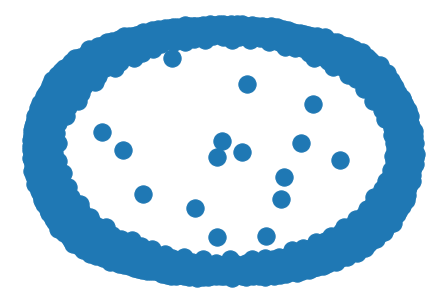

In [13]:
nx.draw(G)
plt.show()

## Part 2 / Stretch: "Play Tennis" Classification

We'll reproduce the "Play Tennis" example from Ross Quinlan's 1986 paper, [Induction of Decison Trees](https://link.springer.com/content/pdf/10.1007%2FBF00116251.pdf).

[According to Wikipedia](https://en.wikipedia.org/wiki/Ross_Quinlan), "John Ross Quinlan is a computer science researcher in data mining and decision theory. He has contributed extensively to the development of decision tree algorithms, including inventing the canonical C4.5 and ID3 algorithms."

#### "Table 1 shows a small training set"

In [14]:
import pandas as pd

columns = 'No. Outlook Temperature Humidity Windy PlayTennis'.split()

raw = """1 sunny hot high false N
2 sunny hot high true N
3 overcast hot high false P
4 rain mild high false P
5 rain cool normal false P
6 rain cool normal true N
7 overcast cool normal true P
8 sunny mild high false N
9 sunny cool normal false P
10 rain mild normal false P
11 sunny mild normal true P
12 overcast mild high true P
13 overcast hot normal false P
14 rain mild high true N"""

data = [row.split() for row in raw.split('\n')]
tennis = pd.DataFrame(data=data, columns=columns).set_index('No.')
tennis['PlayTennis'] = (tennis['PlayTennis'] == 'P').astype(int)

tennis

,Outlook,Temperature,Humidity,Windy,PlayTennis
No.,,,,,
1,sunny,hot,high,false,0
2,sunny,hot,high,true,0
3,overcast,hot,high,false,1
4,rain,mild,high,false,1
5,rain,cool,normal,false,1
6,rain,cool,normal,true,0
7,overcast,cool,normal,true,1
8,sunny,mild,high,false,0
9,sunny,cool,normal,false,1


#### "A decision tree that correctly classifies each object in the training set is given in Figure 2."

<img src="https://i.imgur.com/RD7d0u0.png" height="300">

In this dataset, the tennis player decided to play on 64% of the days, and decided not to on 36% of the days.

In [15]:
tennis['PlayTennis'].value_counts(normalize=True) * 100

1    64.285714
0    35.714286
Name: PlayTennis, dtype: float64

The tennis player played on 100% of the overcast days, 40% of the sunny days, and 60% of the  rainy days

In [16]:
tennis.groupby('Outlook')['PlayTennis'].mean() * 100

Outlook
overcast    100.0
rain         60.0
sunny        40.0
Name: PlayTennis, dtype: float64

On sunny days, the tennis player's decision depends on the humidity. (The Outlook and Humidity features interact.)

In [17]:
sunny = tennis[tennis['Outlook']=='sunny']
sunny.groupby('Humidity')['PlayTennis'].mean() * 100

Humidity
high        0
normal    100
Name: PlayTennis, dtype: int32

On rainy days, the tennis player's decision depends on the wind. (The Outlook and Windy features interact.)

In [18]:
rainy = tennis[tennis['Outlook']=='rain']
rainy.groupby('Windy')['PlayTennis'].mean() * 100

Windy
false    100
true       0
Name: PlayTennis, dtype: int32

#### Before modeling, we will ["encode" categorical variables, using pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html?highlight=get_dummies#computing-indicator-dummy-variables)

In [19]:
y = tennis['PlayTennis']
X = pd.get_dummies(tennis.drop(columns='PlayTennis'))
X

,Outlook_overcast,Outlook_rain,Outlook_sunny,Temperature_cool,Temperature_hot,Temperature_mild,Humidity_high,Humidity_normal,Windy_false,Windy_true
No.,,,,,,,,,,
1,0,0,1,0,1,0,1,0,1,0
2,0,0,1,0,1,0,1,0,0,1
3,1,0,0,0,1,0,1,0,1,0
4,0,1,0,0,0,1,1,0,1,0
5,0,1,0,1,0,0,0,1,1,0
6,0,1,0,1,0,0,0,1,0,1
7,1,0,0,1,0,0,0,1,0,1
8,0,0,1,0,0,1,1,0,1,0
9,0,0,1,1,0,0,0,1,1,0


## Train a Decision Tree Classifier
Get a score of 100% (accuracy)

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [20]:
X_train, X_test, y_train, y_test = \
train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
print('Decision Tree Classifier score: ', tree.score(X_test, y_test))

Decision Tree Classifier score:  1.0


## Compare to Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [21]:
from sklearn.linear_model import LogisticRegression

log_regr = LogisticRegression(solver='lbfgs')
log_regr.fit(X_train, y_train)
print('Logistic Regreesion score: ', log_regr.score(X_test, y_test))

Logistic Regreesion score:  0.6666666666666666


## Visualize the tree
https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

In [22]:
export_graphviz(tree, out_file='classifier_tree.dot')
!dot -Tpng classifier_tree.dot -o tree.png

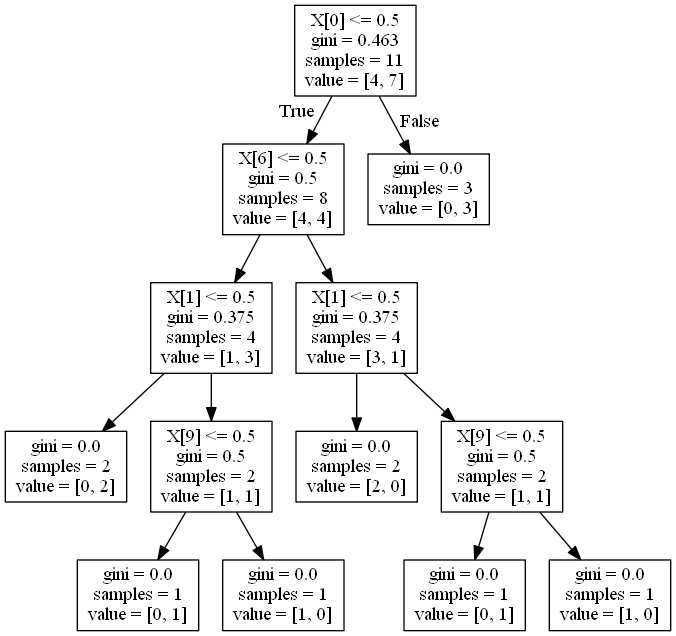

In [23]:
Image('./tree.png')